  2%|▏         | 38/2000 [00:41<13:09,  2.49it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [13:13<00:00,  2.52it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1184 - loss: 3.5957 - val_accuracy: 0.0375 - val_loss: 3.7742
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3058 - loss: 2.4359 - val_accuracy: 0.0975 - val_loss: 3.5756
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4189 - loss: 1.9750 - val_accuracy: 0.1100 - val_loss: 3.3759
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4936 - loss: 1.7387 - val_accuracy: 0.2050 - val_loss: 3.0604
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5353 - loss: 1.5388 - val_accuracy: 0.1800 - val_loss: 2.8652
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5469 - loss: 1.4697 - val_accuracy: 0.3475 - val_loss: 2.4759
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5843 - loss: 1.3821 - val_accuracy: 0.3350 - val_loss: 2.2408
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6331 - loss: 1.1672 - val_accuracy: 0.4125 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


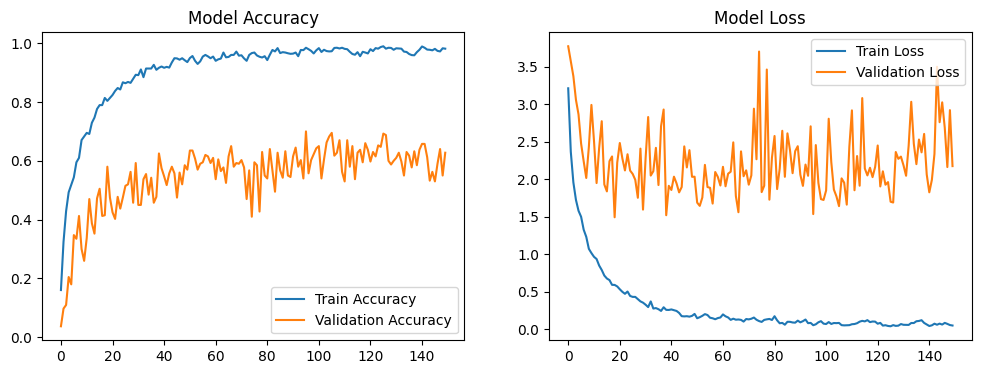

ESC-50 model saved successfully at: /content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_mfcc_gtcc_chroma_mel_ESC50_model.h5


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

def extract_features(file_path, sr=22050, n_mfcc=40, n_gtcc=40, n_chroma=12, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if len(y) < sr * 0.1:
            print(f"Skipping short audio file: {file_path}")
            return None

        # Extract Features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        gtcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_gtcc)  # Placeholder for GTCC, as GTCC is not native to Librosa
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mfcc = resize_feature(mfcc, target_size)
        gtcc = resize_feature(gtcc, target_size)
        chroma = resize_feature(chroma, target_size)
        mel_spec = resize_feature(mel_spec, target_size)

        stacked_features = np.stack([mfcc, gtcc, chroma, mel_spec], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]
    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

if len(X) == 0:
    raise RuntimeError("No valid audio files were processed. Check dataset paths and file integrity.")

X = np.array(X)
y = to_categorical(y, num_classes=50)
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

class ESC50ModelTrainer:
    def __init__(self, input_shape=(128, 128, 4), num_classes=50):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1024))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dense(self.num_classes, activation='softmax'))
        return model

    def compile_model(self):
        self.model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

trainer = ESC50ModelTrainer()
trainer.compile_model()
model = trainer.model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Extract Training and Validation Accuracy
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

# Evaluate Model on Test Set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print Metrics
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


# Save the trained ESC-50 model
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_mfcc_gtcc_chroma_mel_ESC50_model.h5"
model.save(esc50_model_path)
print(f"ESC-50 model saved successfully at: {esc50_model_path}")



ESC-50 Model Input Shape: (None, 128, 128, 4)
UrbanSound8K model built successfully!


  1%|          | 67/8732 [00:10<10:49, 13.34it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 24%|██▍       | 2126/8732 [03:33<06:06, 18.03it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold3/151359-1-2-0.wav


 41%|████      | 3557/8732 [06:09<10:20,  8.33it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold2/17307-1-0-0.wav


 95%|█████████▌| 8332/8732 [14:00<00:16, 23.82it/s]

Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-1-0.wav
Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-2-0.wav
Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-3-0.wav
Skipping silent or short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-4-0.wav


100%|██████████| 8732/8732 [14:38<00:00,  9.94it/s]


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.1979 - loss: 2.3365 - val_accuracy: 0.3723 - val_loss: 2.1663
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.3910 - loss: 1.7747 - val_accuracy: 0.4748 - val_loss: 1.8255
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.4816 - loss: 1.5379 - val_accuracy: 0.5183 - val_loss: 1.4614
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.5306 - loss: 1.3918 - val_accuracy: 0.5321 - val_loss: 1.3781
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.5576 - loss: 1.2795 - val_accuracy: 0.5825 - val_loss: 1.2715
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.6084 - loss: 1.2058 - val_accuracy: 0.6031 - val_loss: 1.2158
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6210 - loss: 1.1468 - val_accuracy: 0.6237 - val_loss: 1.1613
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.6606 - loss: 1.0560 - val_accu

Fine-tuned UrbanSound8K model saved successfully at: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/CNN2_mfcc_gtcc_chroma_mel_ESC50_UrbanSound8K_model.h5


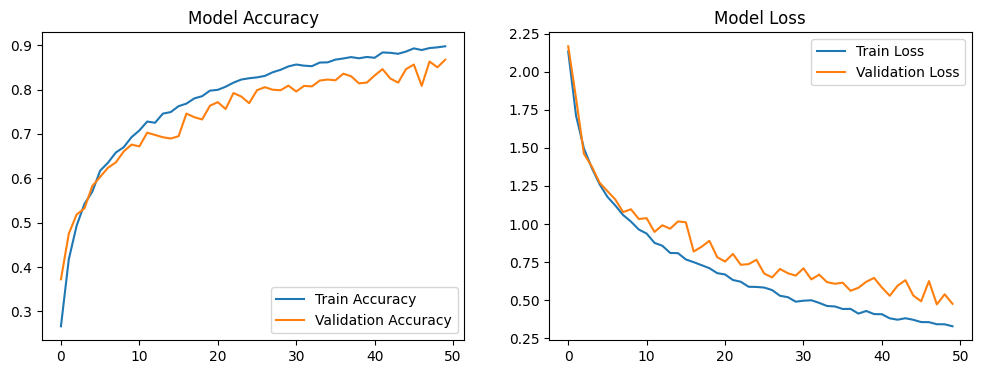

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------- Load Pre-trained ESC-50 Model -------------------
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_mfcc_chroma_mel_gtcc_ESC50_model.h5"
if not os.path.exists(esc50_model_path):
    raise FileNotFoundError(f"ESC-50 trained model not found at: {esc50_model_path}")

base_model = load_model(esc50_model_path)

# 🔹 Print input shape to confirm it expects (128, 128, 4)
print("ESC-50 Model Input Shape:", base_model.input_shape)

# ------------------- Modify Model for UrbanSound8K -------------------
input_layer = Input(shape=(128, 128, 4))  # UrbanSound8K should have 4 channels
x = base_model(input_layer, training=False)  # Pass input through pre-trained model (Freeze ESC-50 layers)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(10, activation='softmax')(x)  # UrbanSound8K has 10 classes

urban_model = Model(inputs=input_layer, outputs=out)
urban_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("UrbanSound8K model built successfully!")

# ------------------- Process UrbanSound8K Dataset -------------------

urbansound_csv = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

urbansound_metadata = pd.read_csv(urbansound_csv)

# 🔹 Fix: Ensure UrbanSound8K has 4 feature channels
def extract_features(file_path, sr=22050, n_mfcc=40, n_gtcc=40, n_chroma=12, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        # Skip short or silent files
        if len(y) < sr * 0.1 or np.sum(y) == 0:
            print(f"Skipping silent or short audio file: {file_path}")
            return None

        # Extract Features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # MFCC
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)  # Chromagram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)  # Mel-Spectrogram
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # 🔹 Handle GTCC (if missing)
        try:
            gtcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_gtcc)  # Placeholder for GTCC
        except:
            gtcc = np.copy(mfcc)  # Use MFCC as GTCC if not available

        def resize_feature(feature, target_size):
            """Ensures feature has shape (128, 128) before stacking"""
            return tf.image.resize(np.expand_dims(feature, axis=-1), target_size).numpy().squeeze()

        # Resize to enforce consistency
        mfcc = resize_feature(mfcc, target_size)
        gtcc = resize_feature(gtcc, target_size)
        chroma = resize_feature(chroma, target_size)
        mel_spec = resize_feature(mel_spec, target_size)

        # Stack all features
        stacked_features = np.stack([mfcc, gtcc, chroma, mel_spec], axis=-1)

        # Ensure final shape is consistent
        if stacked_features.shape != (128, 128, 4):
            print(f"Skipping due to inconsistent shape: {stacked_features.shape} for file {file_path}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Load and process UrbanSound8K dataset
X_urban, y_urban = [], []
for _, row in tqdm(urbansound_metadata.iterrows(), total=len(urbansound_metadata)):
    file_path = os.path.join(urbansound_audio_dir, f"fold{row['fold']}", row['slice_file_name'])
    label = row['classID']
    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue
    features = extract_features(file_path)
    if features is not None:
        X_urban.append(features)
        y_urban.append(label)

if len(X_urban) == 0:
    raise RuntimeError("No valid UrbanSound8K audio files were processed.")

# Convert to NumPy arrays
X_urban = np.array(X_urban)
y_urban = to_categorical(y_urban, num_classes=10)

# Train-test split
X_train_urban, X_test_urban, y_train_urban, y_test_urban = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)

# Fine-tune the model on UrbanSound8K
history_urban = urban_model.fit(X_train_urban, y_train_urban, epochs=50, batch_size=32, validation_data=(X_test_urban, y_test_urban))

# Save the fine-tuned model
urban_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/CNN2_mfcc_gtcc_chroma_mel_ESC50_UrbanSound8K_model.h5"
urban_model.save(urban_model_path)
print(f"Fine-tuned UrbanSound8K model saved successfully at: {urban_model_path}")

# ------------------- Plot Training History -------------------

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_urban.history['accuracy'], label='Train Accuracy')
plt.plot(history_urban.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_urban.history['loss'], label='Train Loss')
plt.plot(history_urban.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [ ]:
# Evaluate model on training data
train_loss, train_accuracy = urban_model.evaluate(X_train_urban, y_train_urban, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate model on test data
test_loss, test_accuracy = urban_model.evaluate(X_test_urban, y_test_urban, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_probs = urban_model.predict(X_test_urban)  # Get probability outputs
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_classes = np.argmax(y_test_urban, axis=1)  # Convert one-hot encoded labels to class labels


from sklearn.metrics import precision_score, recall_score, f1_score


# Compute precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# Ensure the import is available
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Debugging step: Check class labels before computing classification report
print("y_true_classes:", type(y_true_classes), y_true_classes.shape)
print("y_pred_classes:", type(y_pred_classes), y_pred_classes.shape)

# Compute classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)])

print("\nClassification Report:\n")
print(report)
print(f"Final Test Accuracy (from classification report): {accuracy_score(y_true_classes, y_pred_classes):.4f}")



Training Accuracy: 0.8997
Test Accuracy: 0.8671
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step
Precision: 0.8789
Recall: 0.8671
F1 Score: 0.8666
y_true_classes: <class 'numpy.ndarray'> (1746,)
y_pred_classes: <class 'numpy.ndarray'> (1746,)

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       215
           1       1.00      0.67      0.80        79
           2       0.69      0.84      0.76       178
           3       0.98      0.69      0.81       209
           4       0.88      0.90      0.89       212
           5       0.88      0.93      0.91       204
           6       1.00      0.94      0.97        68
           7       0.89      0.94      0.92       191
           8       0.96      0.84      0.90       170
           9       0.80      0.88      0.84       220

    accuracy                           0.87      1746
   macro avg       0.89      0.86      0.87      1746
weighted avg       0.88      0.87  

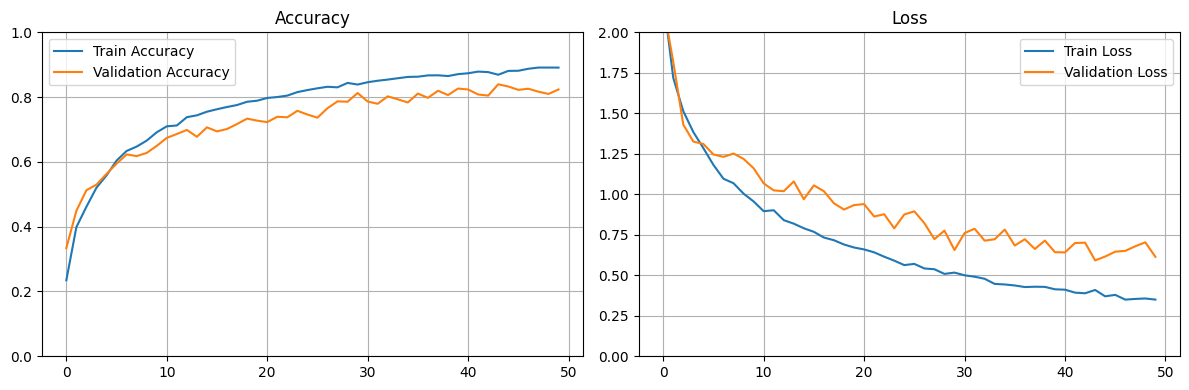

CNN2 training history saved!


In [ ]:
# Plot Training History
# ============================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_urban.history['accuracy'], label='Train Accuracy')
plt.plot(history_urban.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_urban.history['loss'], label='Train Loss')
plt.plot(history_urban.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ============================
# Save Training History as .npy
# ============================
result_dir = "/content/drive/MyDrive/Colab Notebooks/Models/Result"
np.save(os.path.join(result_dir, "cnn2_mfcc_chroma_mel_gtcc_train_acc.npy"), history_urban.history['accuracy'])
np.save(os.path.join(result_dir, "cnn2_mfcc_chroma_mel_gtcc_val_acc.npy"), history_urban.history['val_accuracy'])
np.save(os.path.join(result_dir, "cnn2_mfcc_chroma_mel_gtcc_train_loss.npy"), history_urban.history['loss'])
np.save(os.path.join(result_dir, "cnn2_mfcc_chroma_mel_gtcc_val_loss.npy"), history_urban.history['val_loss'])

print("CNN2 training history saved!")
